****Задача: проанализировать результаты АБ-теста и составить предложения по результатам анализа.
В файле FRU_analytics_test.csv находятся исходные данные АБ-теста:****
- ClientID - ID пользователя, попавшего в тест
- tag - группа, в которую попал пользователь (control/test)
- donation_type - тип пожертвования (one-time - разовое пожертвование, recurring -
регулярное пожертвование с частотой раз в месяц). Если ‘-‘, то пользователь не
совершал пожертвование
- AmountInUSD - размер пожертвования в $. Если ‘-‘, то пользователь не совершал
пожертвование

__________

**Решение**

***Подключение библиотек и скриптов***

In [1]:
import pandas as pd
from datetime import date, timedelta, datetime
import numpy as np
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests
import numpy as np, scipy.stats as st

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def reduce_mem_usage(df):

    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
             
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

***Путь к директориям и файлам***

In [5]:
DATASET_PATH = './FRU_data_task1.csv'

**Загрузка данных**

In [6]:
data_df = pd.read_csv(DATASET_PATH)

**Приведение типов**

In [7]:
data_df.dtypes

ClientID          int64
tag              object
donation_type    object
AmountInUSD      object
dtype: object

In [8]:
data_df['ClientID'] = data_df['ClientID'].astype(str)
data_df['tag'] = data_df['tag'].astype(str)
data_df['donation_type'] = data_df['donation_type'].astype(str)
data_df['AmountInUSD'] = np.where((data_df['AmountInUSD'] == '-'), 0, data_df['AmountInUSD'])
data_df['AmountInUSD'] = data_df['AmountInUSD'].astype(np.float64)

In [9]:
reduce_mem_usage(data_df)

Memory usage of dataframe is 0.62 MB
Memory usage after optimization is: 0.93 MB
Decreased by -50.7%


,ClientID,tag,donation_type,AmountInUSD
0,218590767,control,-,0.0
1,711128717,control,one-time,113.0
2,621634461,control,one-time,137.0
3,991325630,test,-,0.0
4,687831879,control,-,0.0
...,...,...,...,...
20228,245090287,control,-,0.0
20229,653085909,test,-,0.0
20230,604992228,test,-,0.0
20231,875340687,control,recurring,39.0


In [10]:
data_df.dtypes

ClientID         category
tag              category
donation_type    category
AmountInUSD       float32
dtype: object

**Первичный визуальный анализ данных**

In [11]:
# Первые пять строк
data_df[:5]

,ClientID,tag,donation_type,AmountInUSD
0,218590767,control,-,0.0
1,711128717,control,one-time,113.0
2,621634461,control,one-time,137.0
3,991325630,test,-,0.0
4,687831879,control,-,0.0


Посмотрим на количество клиентов, у которых не было оплат в тестовой и контрольной группе:

In [12]:
control_df = data_df.loc[data_df['tag'] == 'control']
test_df = data_df.loc[data_df['tag'] == 'test']

In [13]:
control_no_pay = data_df[(data_df['tag']=='control') & (data_df['donation_type']=='-')]
test_no_pay = data_df[(data_df['tag']=='test') & (data_df['donation_type']=='-')]

In [14]:
control_no_pay.shape[0], test_no_pay.shape[0]

(8277, 8252)

Посмотрим сколько клиентов не платят в каждой группе в процентном выражении

In [15]:
pay_ratio_control = control_no_pay.shape[0] / control_df.shape[0]
pay_ratio_test = test_no_pay.shape[0] / test_df.shape[0]

print('Процент клиентов, которые не платят в группе control: {:.1f}%\n'
     'Процент клиентов, которые не платят в группе test: {:.1f}%'.format(pay_ratio_control*100, pay_ratio_test*100))

Процент клиентов, которые не платят в группе control: 82.4%
Процент клиентов, которые не платят в группе test: 81.0%


Отбросим всех клиентов, платежи которых не поступали

In [16]:
data_pay_df = data_df.loc[data_df['donation_type'] != '-']

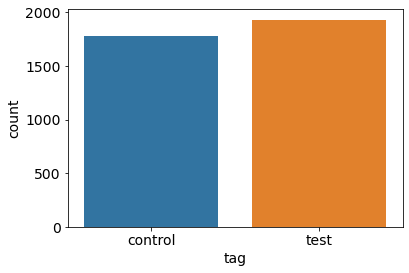

In [17]:
sns.countplot(x = 'tag', data = data_pay_df)
plt.show()

Нас интересуют значения в категория "donation_type" и "AmountInUSD". Поэтому посмотрим на состав значений в этих категориях

Посмотрим как выглядит AmountInUSD

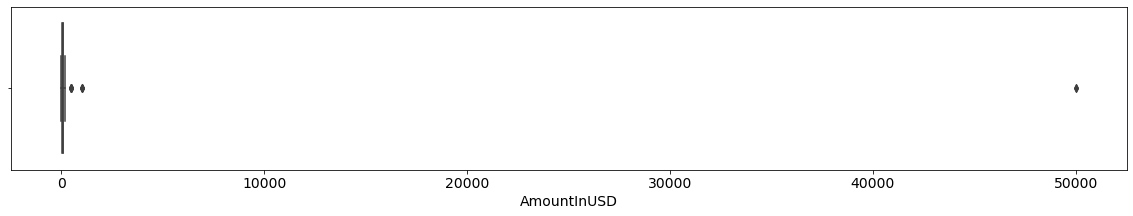

In [18]:
plt.figure(figsize=(20, 3))

sns.boxplot(data_pay_df['AmountInUSD'], whis=2.5)

plt.xlabel('AmountInUSD')
plt.show()

Удалим выбросы, чтобы они не влияли

In [19]:
iqr = data_pay_df['AmountInUSD'].quantile(.75) - data_pay_df['AmountInUSD'].quantile(.25)

Буду считать выбросом сверху все, что лежит выше quantile(.75) + 1.5iqr

In [20]:
data_pay_df = data_pay_df.loc[data_pay_df['AmountInUSD'] < (data_pay_df['AmountInUSD'].quantile(.75) + 1.5*iqr)]

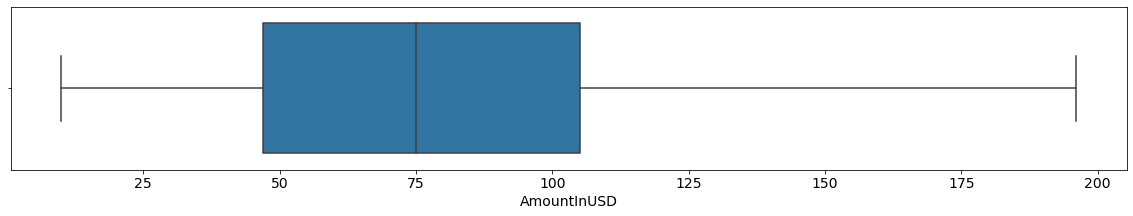

In [21]:
plt.figure(figsize=(20, 3))

sns.boxplot(data_pay_df['AmountInUSD'], whis=2.5)

plt.xlabel('AmountInUSD')
plt.show()

<AxesSubplot:ylabel='Frequency'>

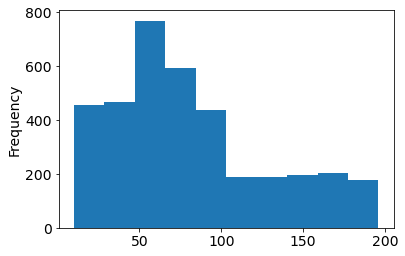

In [22]:
data_pay_df['AmountInUSD'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

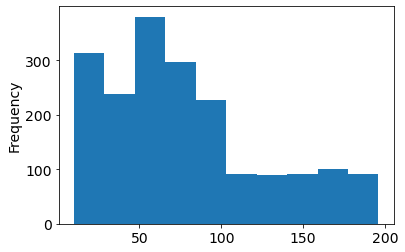

In [24]:
test_pay_df = data_pay_df.loc[data_pay_df['tag'] == 'test']
control_pay_df = data_pay_df.loc[data_pay_df['tag'] == 'control']

Посмотрим на "donation_type"

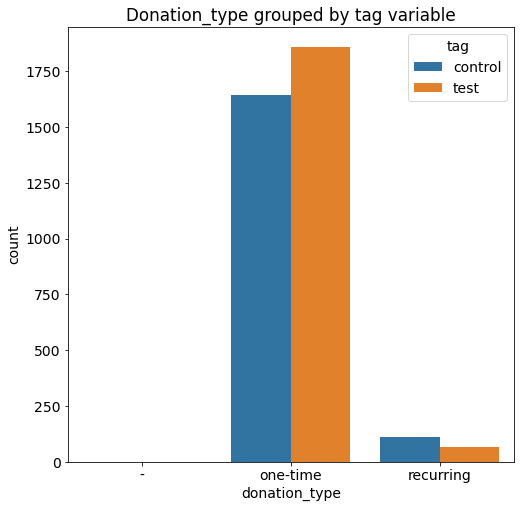

In [25]:
plt.figure(figsize=(8, 8))

sns.countplot(x="donation_type", hue='tag', data=data_pay_df)
plt.title('Donation_type grouped by tag variable')
plt.legend(title='tag', loc='upper right')

plt.show()

Посмотрим соотношение оплат в обеих группах

In [26]:
type_ratio_control = control_pay_df[control_pay_df['donation_type'] == 'one-time'].shape[0] \
                        / control_pay_df.shape[0]
type_ratio_test = test_pay_df[test_pay_df['donation_type'] == 'one-time'].shape[0] \
                        / test_pay_df.shape[0]

print('Процент клиентов, которые платят один раз в группе control: {:.1f}%\n'
     'Процент клиентов, которые платят один раз test: {:.1f}%'.format(type_ratio_control*100, type_ratio_test*100))

Процент клиентов, которые платят один раз в группе control: 93.7%
Процент клиентов, которые платят один раз test: 96.7%


In [28]:
test_pay_df.describe()

,AmountInUSD
count,1920.000000
mean,76.566666
std,49.415134
min,10.000000
25%,39.000000
50%,70.000000
75%,100.000000
max,196.000000


In [29]:
control_pay_df.describe()

,AmountInUSD
count,1751.000000
mean,83.344376
std,47.884331
min,10.000000
25%,50.000000
50%,75.000000
75%,112.000000
max,196.000000


In [33]:
print("Разница между средними в процентах от значения до внедрения:", 
      (test_pay_df.mean() - control_pay_df.mean())/control_pay_df.mean()*100)

Разница между средними в процентах от значения до внедрения: AmountInUSD   -8.132174
dtype: float64


In [34]:
print("Разница между медианами в процентах от значения до внедрения:", 
      (test_pay_df.median() - control_pay_df.median())/control_pay_df.median()*100)

Разница между медианами в процентах от значения до внедрения: AmountInUSD   -6.666667
dtype: float64


По полученным данным видим что AmountInUSD после того как было убрано предзаполнение поля ввода суммы уменьшилась в среднем на 7,3 процента. Теперь статистически проверим гипотезу о том что отстутсвие предзаполнение поля ввода суммы действительно влияет.

Построим доверительные интервалы для медиан и средних значений оплат до test и сontrol.

#### Интервальная оценка медианы

In [50]:
# Доверительные интервалы для медиан

before_median_stat_intervals = st.t.interval(0.95, len(control_pay_df)-1,
                                             loc=np.median(control_pay_df['AmountInUSD']), 
                                             scale=st.sem(control_pay_df['AmountInUSD']))





after_median_stat_intervals = st.t.interval(0.95, len(test_pay_df)-1, \
                                            loc=np.median(test_pay_df['AmountInUSD']), \
                                            scale=st.sem(test_pay_df['AmountInUSD']))

print("95% доверительный интервал для значений медианы AmountInUS  до внедрения:", \
     before_median_stat_intervals)
print("95% доверительный интервал для значений медианы AmountInUS после внедрения:", \
      after_median_stat_intervals)

95% доверительный интервал для значений медианы конверсии до внедрения: (72.75560749060385, 77.24439250939615)
95% доверительный интервал для значений медианы конверсии после внедрения: (67.78827260852484, 72.21172739147516)


####  Интервальная оценка средних

In [51]:
# Доверительные интервалы для средних

before_mean_stat_intervals = st.t.interval(0.95, len(control_pay_df)-1, 
                                           loc=np.mean(control_pay_df['AmountInUSD']), 
                                           scale=st.sem(control_pay_df['AmountInUSD']))
after_mean_stat_intervals = st.t.interval(0.95, len(test_pay_df)-1, 
                                          loc=np.mean(test_pay_df['AmountInUSD']), 
                                          scale=st.sem(test_pay_df['AmountInUSD']))

print("95% доверительный интервал для значений средней AmountInUS до внедрения:", before_mean_stat_intervals)
print("95% доверительный интервал для значений средней AmountInUS после внедрения:", after_mean_stat_intervals)

95% доверительный интервал для значений средней конверсии до внедрения: (81.09998310095541, 85.58876811974771)
95% доверительный интервал для значений средней конверсии после внедрения: (74.3549382579389, 78.77839304088923)


***Оценка различий между данными до и после при помощи критерия Манна — Уитни***

In [119]:
statistic, pvalue = stats.mannwhitneyu(control_amount, test_amount)
print("Критерий Манна — Уитни", pvalue)

Критерий Манна — Уитни 1.0482048340947425e-06


#### Поправка Холма-Бонферрони

In [120]:
reject, p_corrected, a1, a2 = multipletests(pvalue, alpha = 0.01, method = 'bonferroni')
print(reject)
print(p_corrected)

[ True]
[1.04820483e-06]


Вероятность появления ошибки мала

#### В итоге, изменения значений AmountInUSD статистически значимы. 
#### Значит на основании данного анализа можно утвержать, что лучше оставить предзаполнение поля ввода суммы. 
#### Потом, возможно, следует  провести другие АБ тестирования по изменению саммой сумму в большую или меньшую сторону